In [311]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('~/styles/clarke-default.mplstyle')
import tensorflow as tf
from tensorflow import keras

In [312]:
save_figures = True
pmt_qe = 0.1 #0.15

In [313]:
mc_truth_pos = []
detected = []
pte = []

with h5py.File('chroma-lxe/s2_sim_test_ss.h5', 'r') as f:
    print(f.keys())
    for key in f.keys():
        if '_detected' in key:
            detected.append(f[key][()])
        elif 'posX' in key:
            mc_truth_pos.append(f[key][()])
        elif 'posY' in key:
            mc_truth_pos.append(f[key][()])
        elif 'posZ' in key:
            mc_truth_pos.append(f[key][()])
        elif key=='pte':
            pte.append(f[key][()])

ss_mc_truth_pos = np.array(mc_truth_pos).swapaxes(0, 1)
ss_n_detected = np.random.binomial(np.array(detected).swapaxes(0, 1).astype(int), pmt_qe)
# ss_pte = np.sum(ss_n_detected, axis=1)/5e4/pmt_qe
ss_pte = np.array(pte)[0]

<KeysViewHDF5 ['ch0_detected', 'ch0_pte', 'ch1_detected', 'ch1_pte', 'ch2_detected', 'ch2_pte', 'ch3_detected', 'ch3_pte', 'detected', 'n', 'posX', 'posY', 'posZ', 'pte', 'time_spent']>


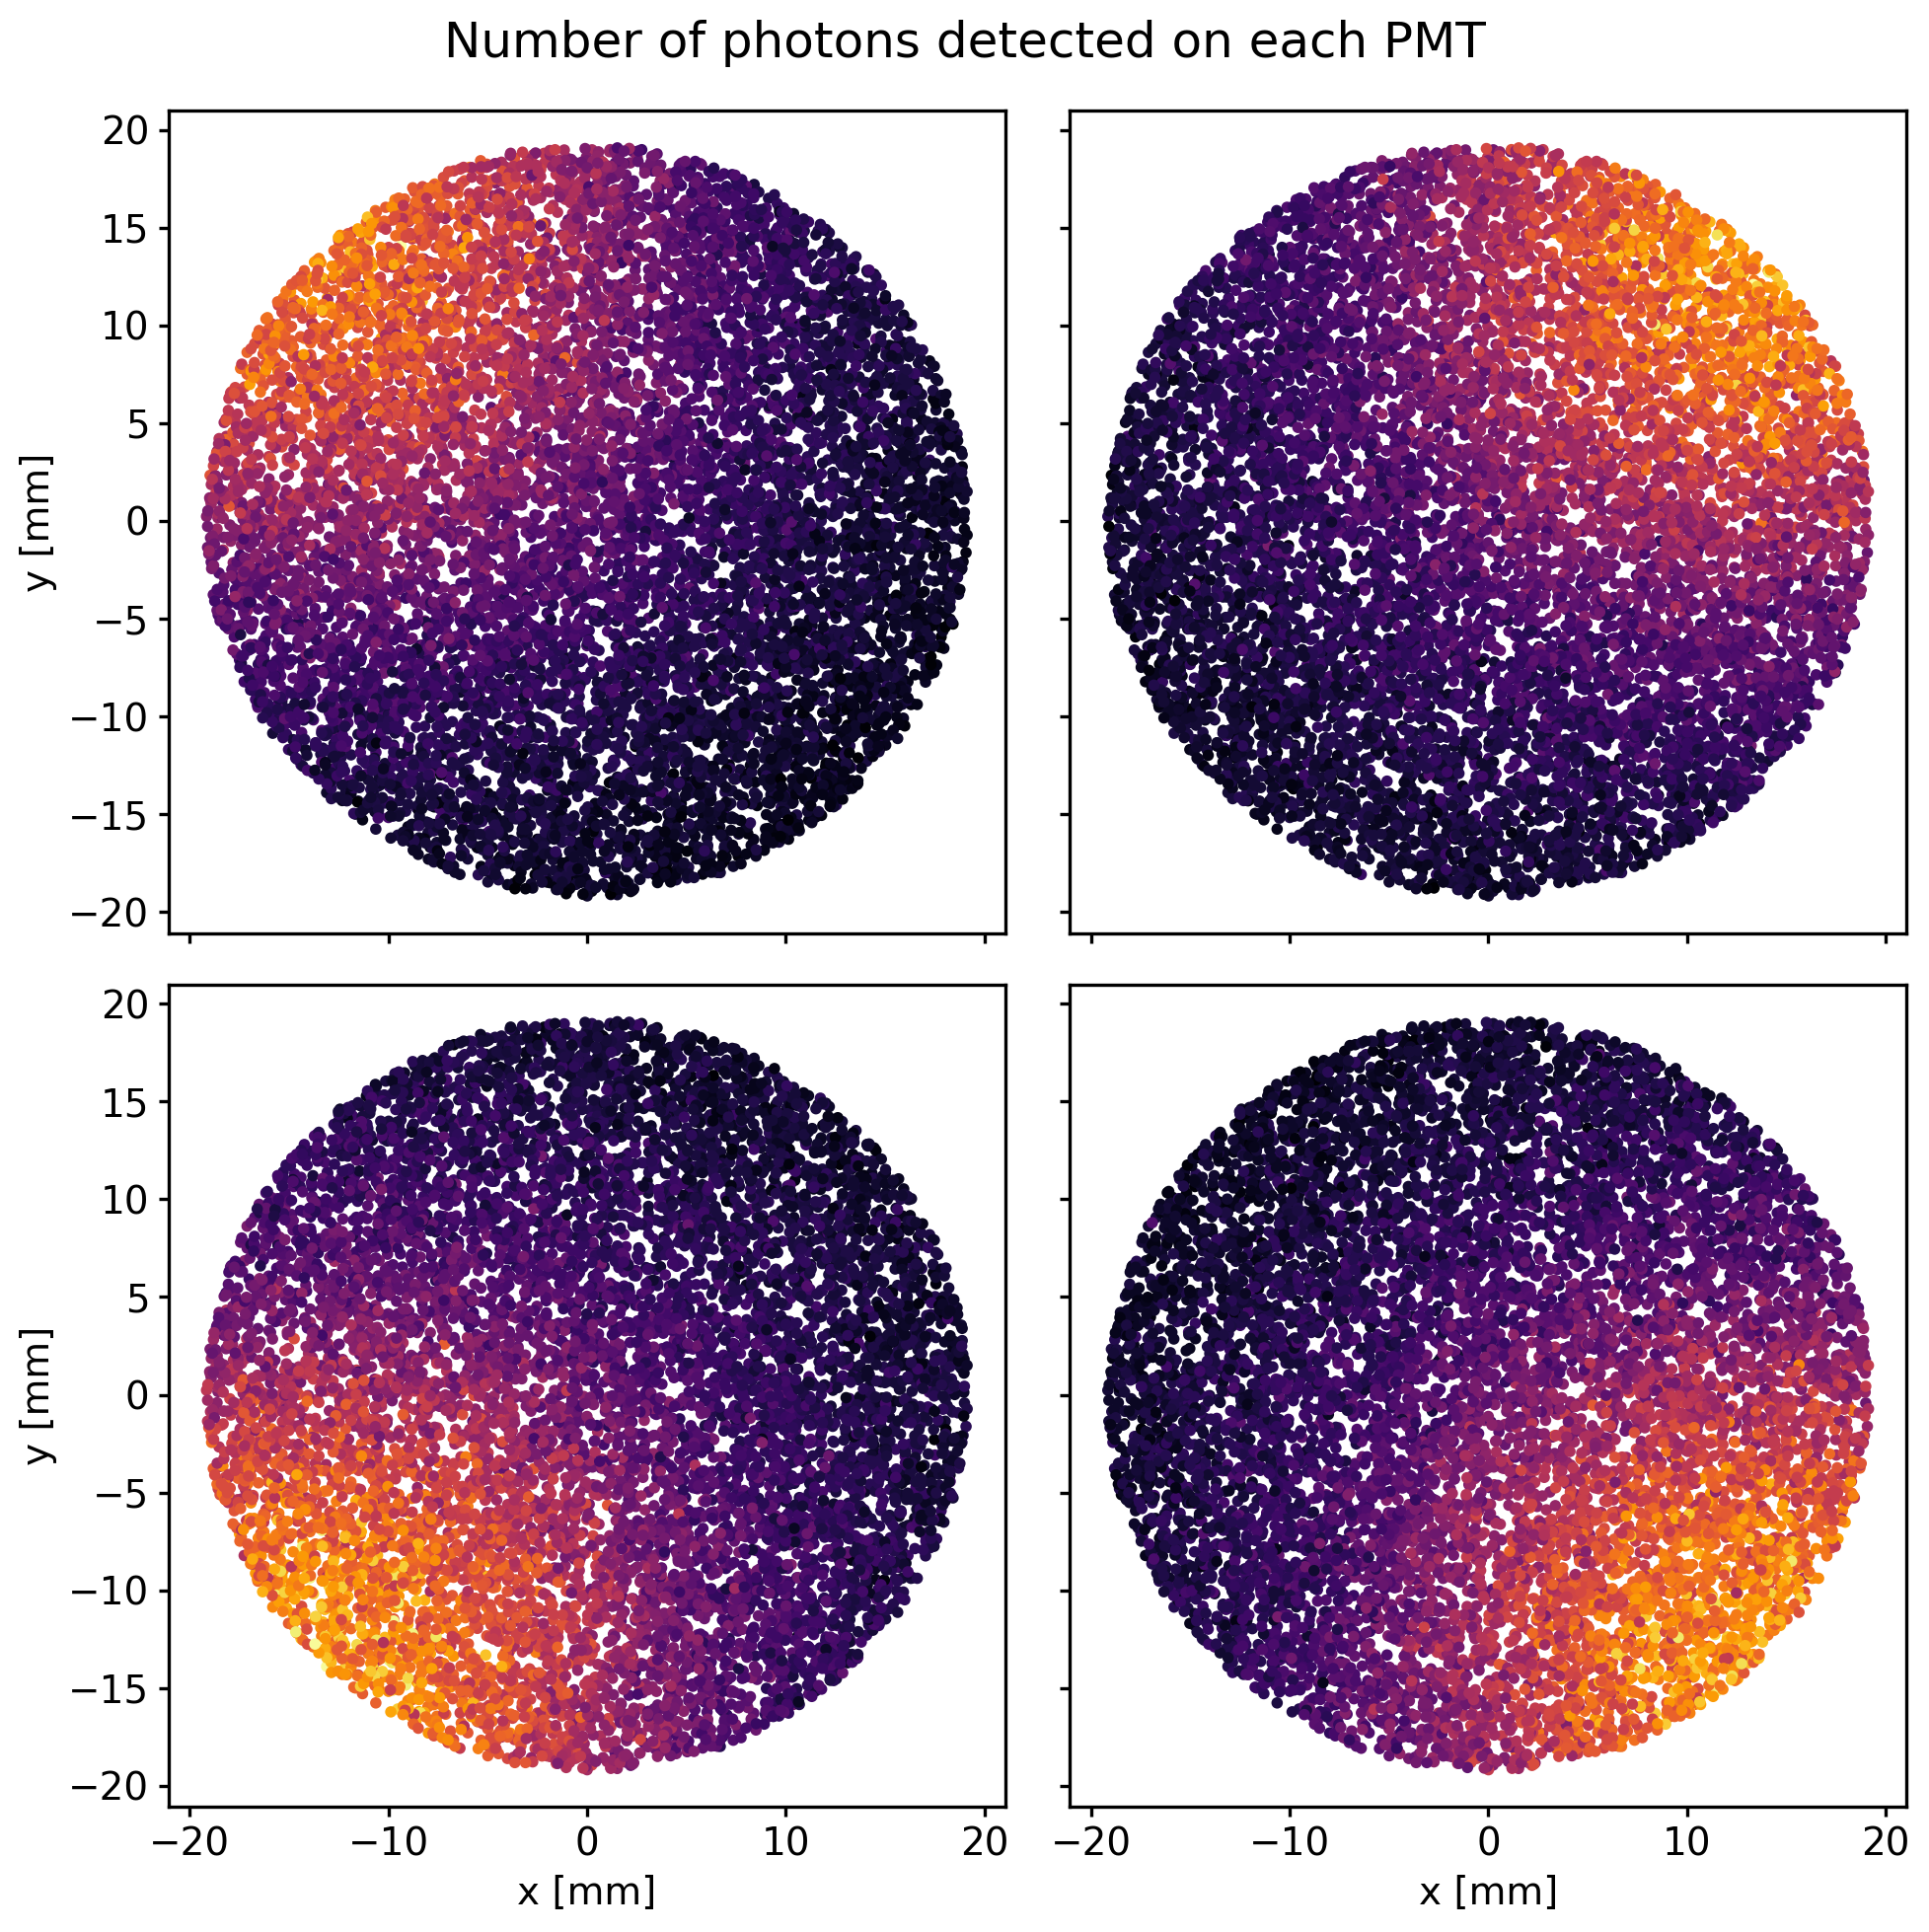

In [314]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex='col', sharey='row')
# for i in range(4):
scatter = ax[1,1].scatter(mc_truth_pos[0], mc_truth_pos[1], c=ss_n_detected[:,0], cmap='inferno', s=10)
scatter = ax[1,0].scatter(mc_truth_pos[0], mc_truth_pos[1], c=ss_n_detected[:,1], cmap='inferno', s=10)
scatter = ax[0,0].scatter(mc_truth_pos[0], mc_truth_pos[1], c=ss_n_detected[:,2], cmap='inferno', s=10)
scatter = ax[0,1].scatter(mc_truth_pos[0], mc_truth_pos[1], c=ss_n_detected[:,3], cmap='inferno', s=10)

ax[1,0].set_xlabel('x [mm]')
ax[1,1].set_xlabel('x [mm]')
ax[0,0].set_ylabel('y [mm]')
ax[1,0].set_ylabel('y [mm]')
# ax[0,0].set_title('MC truth position of events on PMT 1')

# Add a colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label('det_1 Value')
fig.suptitle('Number of photons detected on each PMT')
if save_figures:
    fig.savefig('/home/clarke/figures/num_photons_by_pmt.png')
plt.tight_layout()
plt.show()

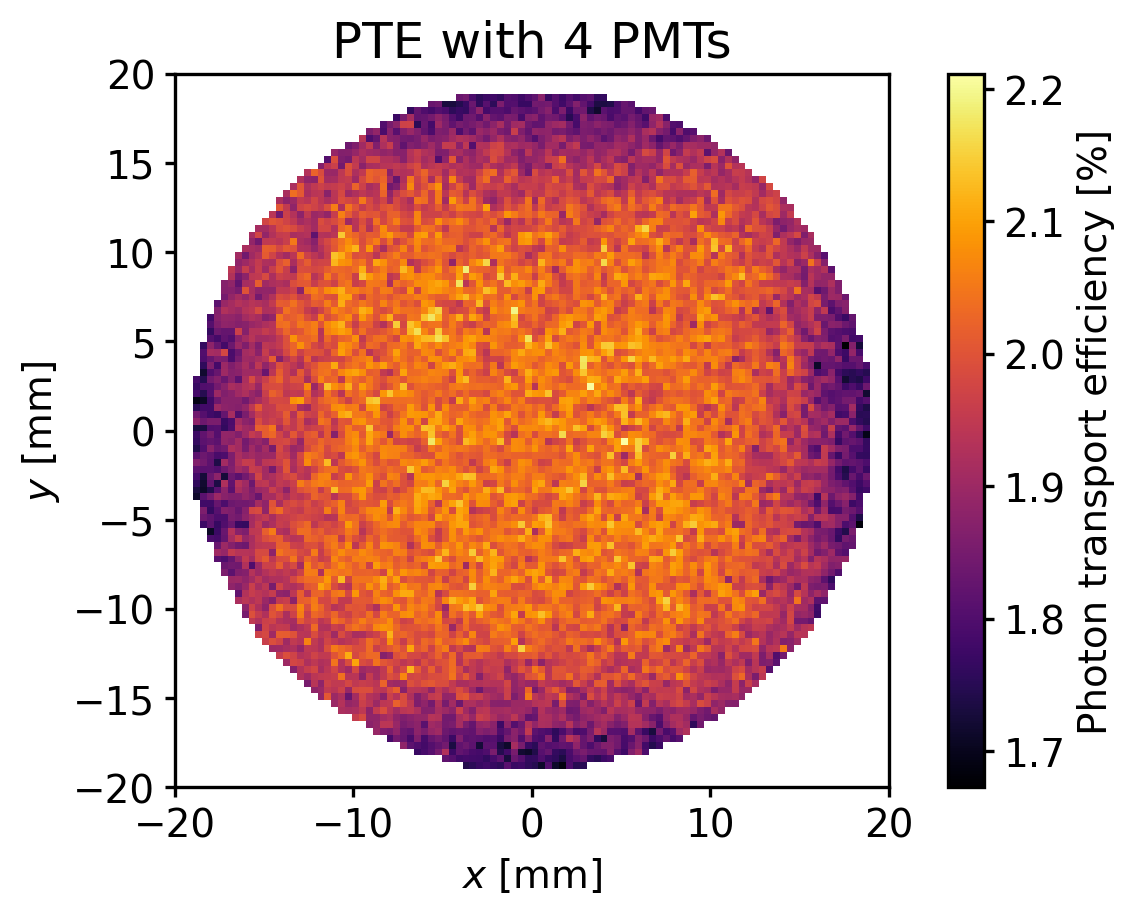

In [315]:
from scipy.interpolate import griddata

xi = np.linspace(np.amin(ss_mc_truth_pos[:,0]), np.amax(ss_mc_truth_pos[:,0]), 100)
yi = np.linspace(np.amin(ss_mc_truth_pos[:,1]), np.amax(ss_mc_truth_pos[:,1]), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((ss_mc_truth_pos[:,0], ss_mc_truth_pos[:,1]), 100*ss_pte, (xi, yi), method='linear')

fig, ax = plt.subplots()
mesh = ax.pcolormesh(xi, yi, zi, cmap='inferno')
ax.set_aspect('equal')
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
cbar = fig.colorbar(mesh)
cbar.set_label('Photon transport efficiency [%]')
ax.set_title('PTE with 4 PMTs')
if save_figures:
    fig.savefig('/home/clarke/figures/pte_map.png')

In [316]:
r = 13.208 + 1*6.451
s = 19.35

angle = np.arctan(2*r/s)
2*np.cos(angle)*2*angle/4./np.pi

0.15650072663822162

In [317]:
mc_truth_pos = []
mc_truth_pos_2 = []
detected = []

with h5py.File('chroma-lxe/s2_sim_test_ms.h5', 'r') as f:
    print(f.keys())
    for key in f.keys():
        if '_detected' in key:
            detected.append(f[key][()])
        elif key=='posX':
            mc_truth_pos.append(f[key][()])
        elif key=='posY':
            mc_truth_pos.append(f[key][()])
        elif key=='posZ':
            mc_truth_pos.append(f[key][()])
        elif key=='posX_2':
            mc_truth_pos_2.append(f[key][()])
        elif key=='posY_2':
            mc_truth_pos_2.append(f[key][()])
        elif key=='posZ_2':
            mc_truth_pos_2.append(f[key][()])

ms_mc_truth_pos = np.array(mc_truth_pos).swapaxes(0, 1)
ms_mc_truth_pos_2 = np.array(mc_truth_pos_2).swapaxes(0, 1)
ms_n_detected = np.random.binomial(np.array(detected).swapaxes(0, 1).astype(int), pmt_qe)

def spatial_sep(pos, pos2):
    """Get the distance between two points in a MS event
    """
    return np.sqrt(np.sum(((pos - pos2)**2)[:,:2], axis=1))

seps = spatial_sep(ms_mc_truth_pos, ms_mc_truth_pos_2)

<KeysViewHDF5 ['ch0_detected', 'ch0_pte', 'ch1_detected', 'ch1_pte', 'ch2_detected', 'ch2_pte', 'ch3_detected', 'ch3_pte', 'detected', 'n', 'posX', 'posX_2', 'posY', 'posY_2', 'posZ', 'posZ_2', 'pte', 'time_spent']>


In [318]:
n_detected = np.concatenate((ss_n_detected, ms_n_detected), axis=0)
ss_truth = np.ones(ss_n_detected.shape[0])
ms_truth = np.zeros(ms_n_detected.shape[0])
truth = np.concatenate((ss_truth, ms_truth), axis=0)
seps_both = np.concatenate((np.zeros_like(seps), seps))

# Generate a random permutation
permutation = np.random.permutation(n_detected.shape[0])

# Apply the permutation to both arrays
n_detected_shuffled = n_detected[permutation]
truth_shuffled = truth[permutation]
seps_shuffled = seps_both[permutation]

In [319]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                320       
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dense_58 (Dense)            (None, 16)                528       
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
10/10 [==============================] - 1s 18ms/step - loss: 0.7926 - accuracy: 0.5648 - val_loss: 0.6414 - val_accuracy: 0.6439
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.6278 - accuracy: 0.6634 - val_loss: 0.6076 - val_accuracy: 0.6855
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.5971 - accuracy: 0.6914 - val_loss: 0.6039 - val_accuracy: 0.6850
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.5940 - accuracy: 0.6920 - val_loss: 0.5954 - val_accuracy: 0.6920
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.5868 - accuracy: 0.6944 - val_loss: 0.5934 - val_accuracy: 0.6932
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.5846 - accuracy: 0.6973 - val_loss: 0.5898 - val_accuracy: 0.6954
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 0.5821 - accuracy: 0.6980 - val_loss: 0.5888 - val_accuracy: 0.6924
Epoch 8/50
10/10 [=

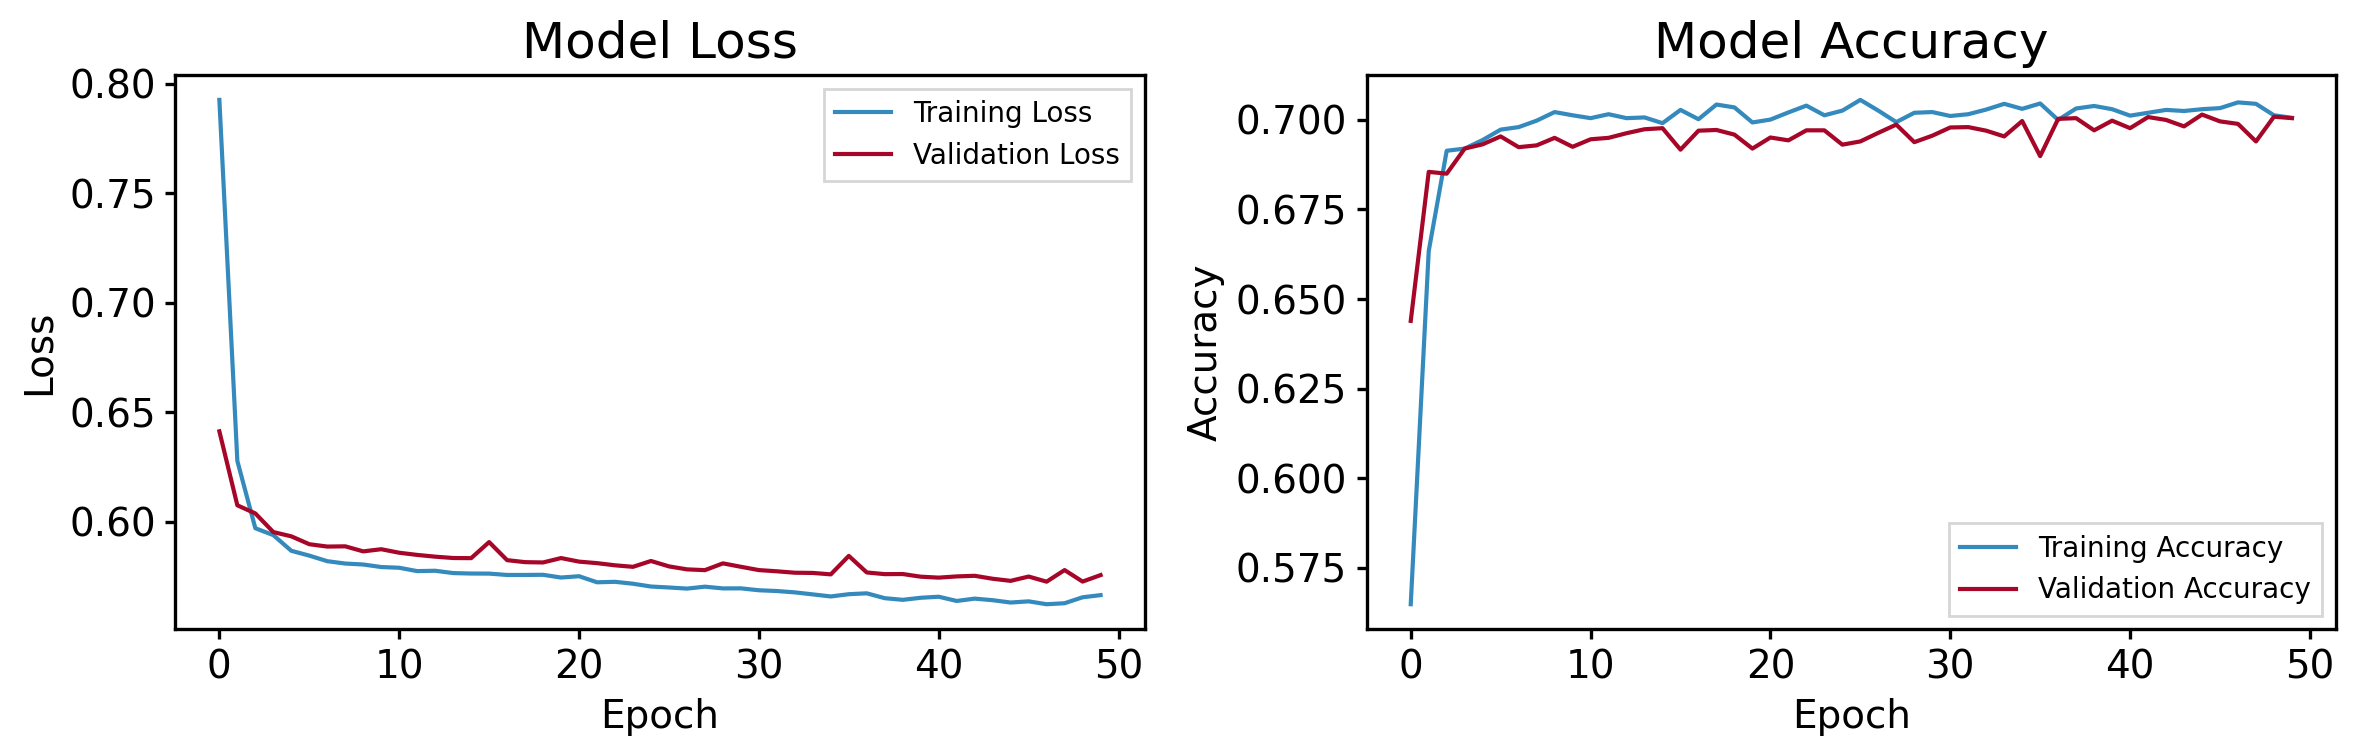

In [320]:
# Split the data into training and validation sets
split_index = len(n_detected_shuffled) // 2
X_train, X_val = n_detected_shuffled[:split_index], n_detected_shuffled[split_index:]
y_train, y_val = truth_shuffled[:split_index], truth_shuffled[split_index:]
seps_train, seps_val = seps_shuffled[:split_index], seps_shuffled[split_index:]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=1000,
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

if save_figures:
    plt.savefig('/home/clarke/figures/training.png')

plt.tight_layout()
plt.show()

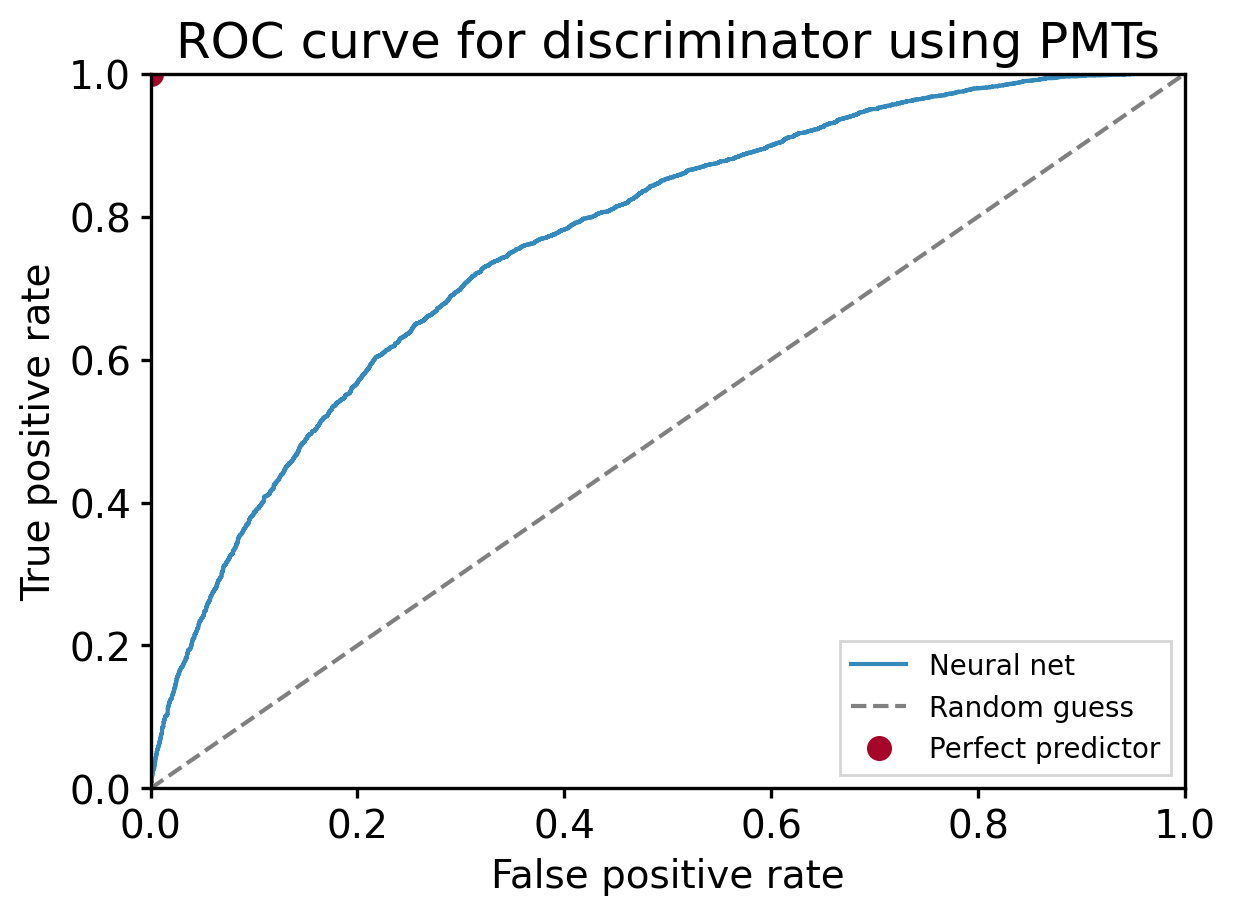

In [321]:
y_pred = np.array(np.array(model(X_val))[:,0])
y_true = np.copy(y_val)

sorted_indices = np.argsort(-y_pred)
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

P = np.sum(y_true)
N = len(y_true) - P

tpr = np.cumsum(y_true_sorted)/P
fpr = np.cumsum(1 - y_true_sorted)/N

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='Neural net')
ax.plot([0, 1], [0, 1], ls='--', color='grey', label='Random guess')
ax.plot([0], [1], marker='o', ls='none', ms=8, label='Perfect predictor')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve for discriminator using PMTs')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')
if save_figures:
    fig.savefig('/home/clarke/figures/roc.png')

titles = ['one', 'ten', 'hundred']
qes = np.array([1e-2, 1e-1, 1e0])
title_ind = np.argwhere(qes==pmt_qe)[0][0]
np.save('qe_' + titles[title_ind] + '.npy', np.vstack((fpr, tpr)))

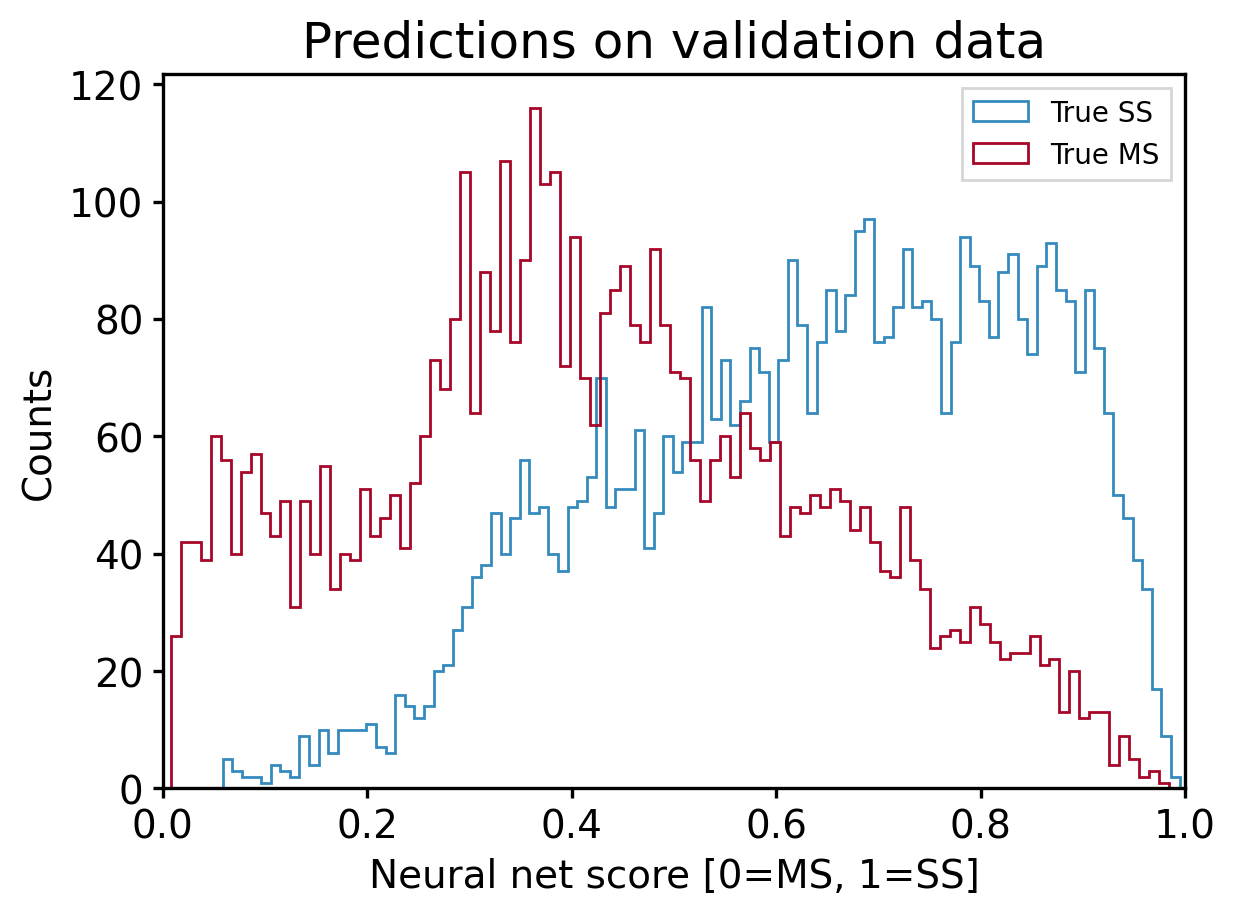

In [325]:
n_bins = 100

fig, ax = plt.subplots()
ax.hist(np.array(model(X_val)[y_val>0.5])[:,0], histtype='step', bins=n_bins, label='True SS')
ax.hist(np.array(model(X_val)[y_val<=0.5])[:,0], histtype='step', bins=n_bins, label='True MS')
ax.set_xlabel('Neural net score [0=MS, 1=SS]')
ax.set_ylabel('Counts')
ax.set_title('Predictions on validation data')
ax.set_xlim([0, 1])
ax.legend()
if save_figures:
    fig.savefig('/home/clarke/figures/pdfs.png')

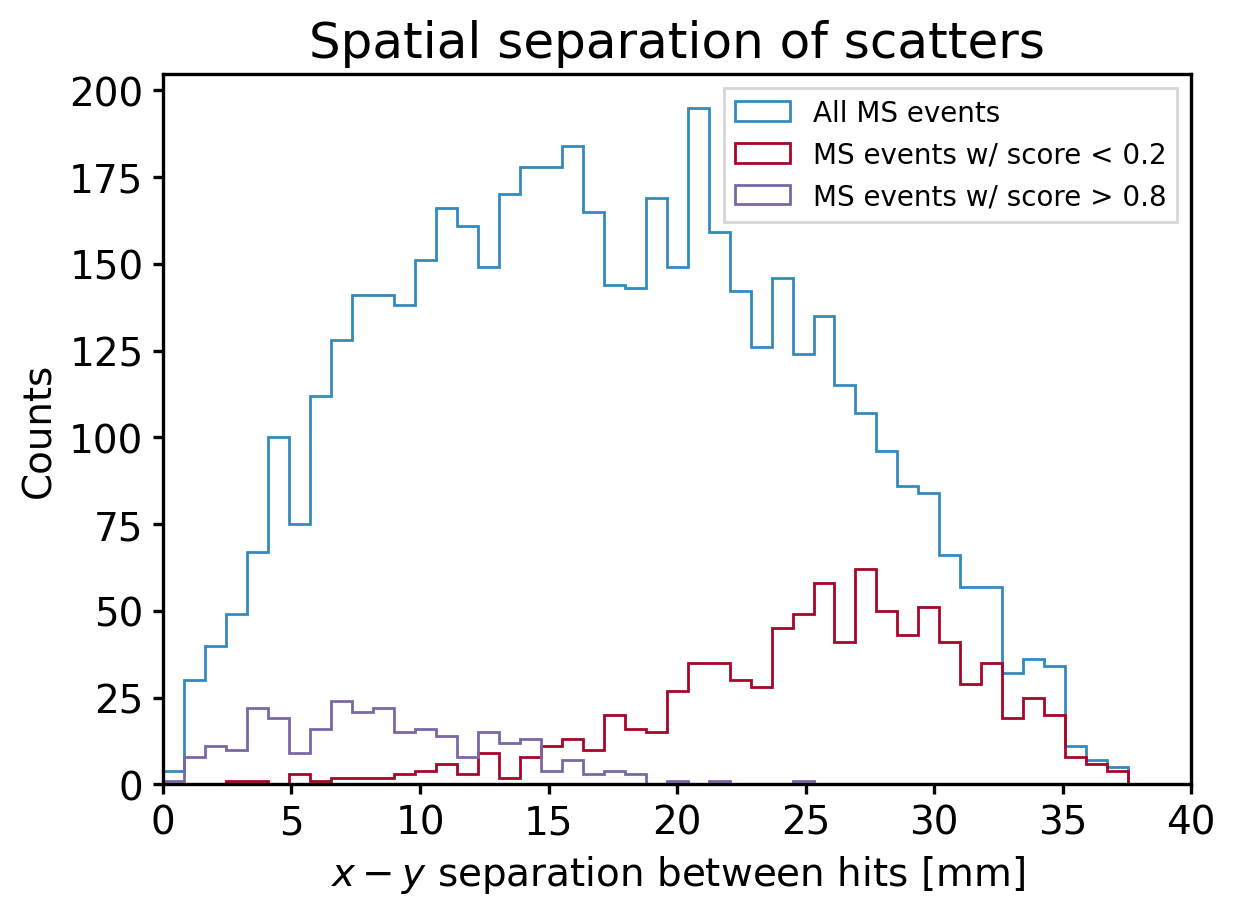

In [323]:
bins = np.linspace(0, 40, 50)

fig, ax = plt.subplots()
ax.hist(seps_val[y_val<0.5], histtype='step', label='All MS events', 
        density=False, bins=bins)
ax.hist(seps_val[(y_val<0.5) & (y_pred<0.2)], histtype='step', label='MS events w/ score < 0.2', \
        density=False, bins=bins)
ax.hist(seps_val[(y_val<0.5) & (y_pred>0.8)], histtype='step', label='MS events w/ score > 0.8', \
        density=False, bins=bins)
ax.set_xlabel('$x-y$ separation between hits [mm]')
ax.set_ylabel('Counts')
ax.set_title('Spatial separation of scatters')
ax.set_xlim([0, 40])
ax.legend()
if save_figures:
    fig.savefig('/home/clarke/figures/by_separation.png')

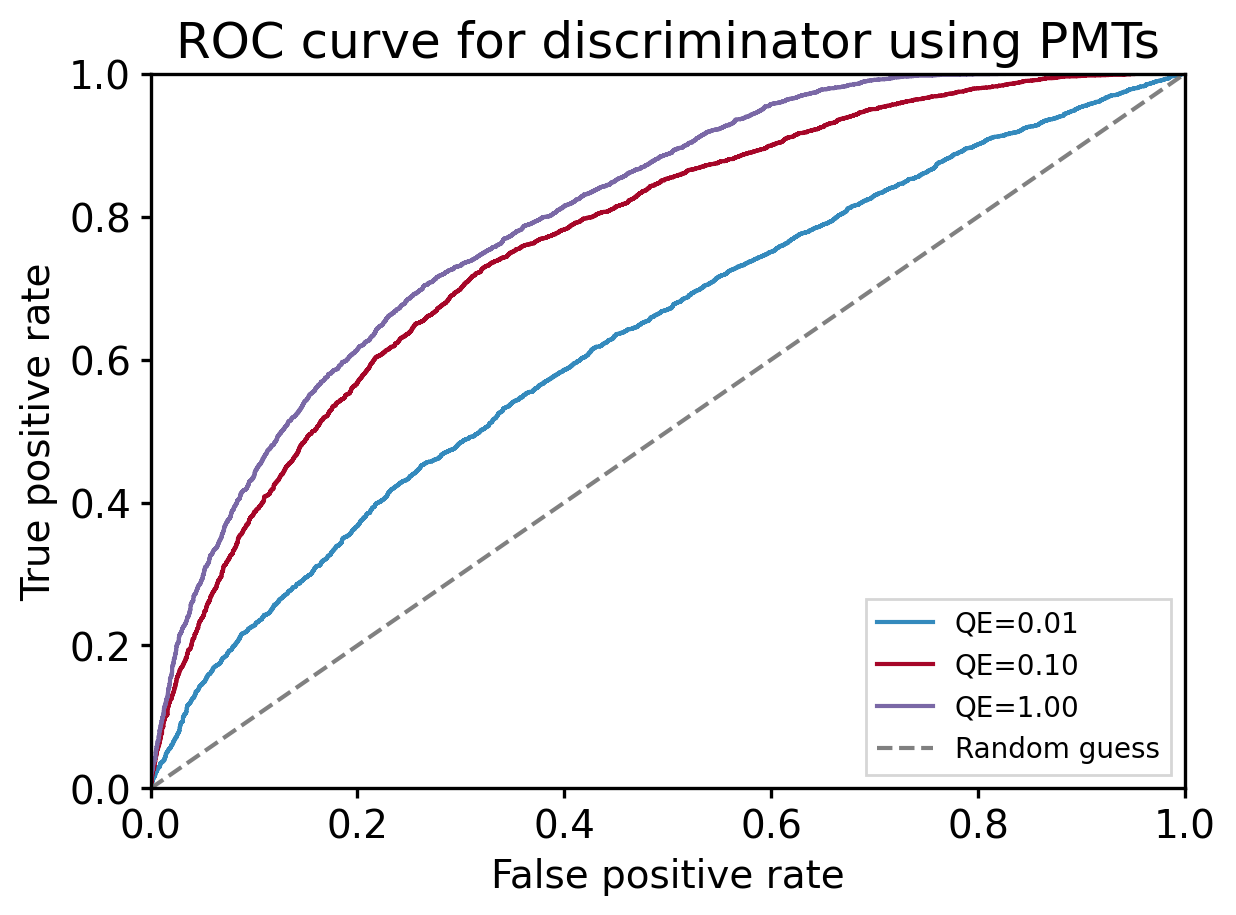

In [324]:
fig, ax = plt.subplots()
for i,title in enumerate(titles):
    fpr, tpr = np.load('qe_' + title + '.npy')
    ax.plot(fpr, tpr, label='QE={:.2f}'.format(qes[i]))
ax.plot([0, 1], [0, 1], ls='--', color='grey', label='Random guess')
#ax.plot([0], [1], marker='o', ls='none', ms=8, label='Perfect predictor')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve for discriminator using PMTs')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')
if save_figures:
    fig.savefig('/home/clarke/figures/roc_comparison.png')